In [1]:
%load_ext autoreload 

In [2]:
%autoreload 2
from ml_switching_reg_sim.monte_carlo import UberDatasetCreator
from ml_switching_reg_sim.utils import create_list_covariance_matrices
import pandas as pd
from datetime import timedelta
from ml_switching_reg.mle import DriverSpecificProbUberMLE
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.append("/Users/lordflaron/Documents/uganda-uber-paper/paper/scripts/")
from regression import RegressionFit

In [ ]:
u = UberDatasetCreator(drivers=1000, time_periods=30, lags=[0,1,2,3,4])

mock_dict = {
    'bases' : [0,1,-1,1],
    'amplitudes' : [2,2,2,2],
    'offsets' : [
        timedelta(days=0),
        timedelta(days=0),
        timedelta(days=60),
        timedelta(days=90)
    ],
    'shock_times' : [
        (10, 15),
        (11,16),
        (20,25),
        (15,25)
    ]
}



/Users/lordflaron/Documents/ml-switching-reg-sim/.venv/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/lordflaron/Documents/ml-switching-reg-sim/.venv/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [26]:

def process_df(df, ):
    drought_aux = (
        df
        .filter(like='drought')
        # .groupby('time').sample(300)
    )

    l_ind= pd.MultiIndex.from_product(
        [[0,1,2,3], ['lagged_0', 'lagged_1', 'lagged_2', 'lagged_3', 'lagged_4']],
        names=['regime', 'lags']
    )

    drought_aux.columns = l_ind

    drought = (   
        drought_aux
        .stack(level=0)
        .rename({f"lagged_{i}" : f"lagged_{i}_drought" for i in range(u.regimes+1)}, axis=1)
        .reset_index('regime')
        .assign(regime = lambda df: "regime_" + df['regime'].astype(str))
        )

    reg_df = (
        df[['y', 'misclass_regime_0', 'misclass_regime_1', 'misclass_regime_2', 'misclass_regime_3']]
        .merge(drought, left_index=True, right_index=True)
        # .rename(columns=lambda x: x.replace("misclass_regime_", "regime_"))
        .astype({'regime' :  str})
        .set_index('regime', append=True)
        .astype(float)
        .assign(predicted_class = lambda df: df[['misclass_regime_0', 'misclass_regime_1', 'misclass_regime_2', 'misclass_regime_3']].idxmax(axis=1).str.replace("misclass_", ""))
        .dropna(subset='y')
        # .assign(y = lambda df: df['y'].where(df['y']>0,0))
        .assign(noise = lambda df: np.random.normal(0,1, size=df.shape[0]))
        .assign(month = lambda df: df.index.get_level_values('time').month)
        .assign(quarter = lambda df: df.index.get_level_values('time').quarter)
        .assign(year = lambda df: df.index.get_level_values('time').year)
        .assign(driver_id = lambda df: df.index.get_level_values('driver'))
        .assign(y = lambda df: df['y'])
        .assign(date_id = lambda df: df.index.get_level_values('time'))
        )

    classifier_pred = reg_df.filter(like='misclass_').reset_index().drop(columns='regime').drop_duplicates().set_index(['driver','time'])
    
    return reg_df, classifier_pred

In [121]:
res_list = []

import warnings; warnings.filterwarnings('ignore')

for w in np.linspace(0,1, 100):

    df, mw, [beta0, beta1], y_sd = u.construct(
        seed=1,
        output_true_beta=True,
        output_sigma=True,
        y_sd = [1,1,1,1],
        reg_ready=True,
        # beta1 = [.3,.2,.4,.1,0],
        beta1 = [.1, .2, .3, .4, .5],
        beta0 = 0,
        driver_fe=True,  
        # month_year_fe=True,
        time_fe=True,
        # drought_mean=[-2,-1,0,1,2],
        mock=True,
        mock_dict=mock_dict,
        weight=w
        )
    
    reg_df, classifier_pred = process_df(df)

    us_fast = DriverSpecificProbUberMLE.from_formula(
        formula = "y ~ -1 + EntityEffects +" + ' + '.join([f"lagged_{i}_drought" for i in u.lags]),
        data=reg_df,
        classifier_pred = classifier_pred,
        cm=mw,
        check_absorbed=False,
    )

    res = us_fast.fit(
                method='bfgs',
                sigma_bound=(0.001, None),
                cluster_var = None,
                check_absorbed=False
            )
    
    res_list.append((w, res))
    
w_df_sr = (
    pd.concat([RegressionFit.as_pandas(sr)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(model = 'sr')
    .query("w<1")
    )

w_df_pols = (
    pd.concat([RegressionFit.as_pandas(pols)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(coef = lambda df: df['Parameter'],
            model='pols')
    .query("w<1")

    )

w_df = pd.concat([w_df_sr, w_df_pols])

w_df.to_csv("coefficents_time_fe_misclassified.csv")

Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.728664
         Iterations: 6
         Function evaluations: 16
         Gradient evaluations: 16
Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.739795
         Iterations: 11
         Function evaluations: 21
         Gradient evaluations: 21
Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.749946
         Iterations: 15
         Function evaluations: 24
         Gradient evaluations: 24
Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.764324
         Iterations: 11
         Function evaluations: 21
         Gradient evaluations: 21
Initializing...
Creating starting values...
Optimizing...
Optimization terminated

In [ ]:
res_list = []

import warnings; warnings.filterwarnings('ignore')

for w in np.linspace(0,1, 100):

    df, mw, [beta0, beta1], y_sd = u.construct(
        seed=1,
        output_true_beta=True,
        output_sigma=True,
        y_sd = [1,1,1,1],
        reg_ready=True,
        # beta1 = [.3,.2,.4,.1,0],
        beta1 = [.1, .2, .3, .4, .5],
        beta0 = 0,
        driver_fe=True,  
        month_year_fe=True,
        # time_fe=True,
        # drought_mean=[-2,-1,0,1,2],
        mock=True,
        mock_dict=mock_dict,
        weight=w
        )
    
    reg_df, classifier_pred = process_df(df)

    us_fast = DriverSpecificProbUberMLE.from_formula(
        formula = "y ~ -1 + EntityEffects + C(month) + C(year)" + ' + '.join([f"lagged_{i}_drought" for i in u.lags]),
        data=reg_df,
        classifier_pred = classifier_pred,
        cm=mw,
        check_absorbed=False,
    )

    res = us_fast.fit(
                method='bfgs',
                sigma_bound=(0.001, None),
                cluster_var = None,
                check_absorbed=False
            )
    
    res_list.append((w, res))
    
w_df_sr = (
    pd.concat([RegressionFit.as_pandas(sr)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(model = 'sr')
    .query("w<1")
    )

w_df_pols = (
    pd.concat([RegressionFit.as_pandas(pols)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(coef = lambda df: df['Parameter'],
            model='pols')
    .query("w<1")

    )

w_df = pd.concat([w_df_sr, w_df_pols])

w_df.to_csv("coefficents_month_year_fe.csv")

In [ ]:
res_list = []

import warnings; warnings.filterwarnings('ignore')

for w in np.linspace(0,1, 100):

    df, mw, [beta0, beta1], y_sd = u.construct(
        seed=1,
        output_true_beta=True,
        output_sigma=True,
        y_sd = [1,1,1,1],
        reg_ready=True,
        # beta1 = [.3,.2,.4,.1,0],
        beta1 = [.1, .2, .3, .4, .5],
        beta0 = 0,
        driver_fe=True,  
        # month_year_fe=True,
        # time_fe=True,
        # drought_mean=[-2,-1,0,1,2],
        mock=True,
        mock_dict=mock_dict,
        weight=w
        )
    
    reg_df, classifier_pred = process_df(df)

    us_fast = DriverSpecificProbUberMLE.from_formula(
        formula = "y ~ -1 + EntityEffects +" + ' + '.join([f"lagged_{i}_drought" for i in u.lags]),
        data=reg_df,
        classifier_pred = classifier_pred,
        cm=mw,
        check_absorbed=False,
    )

    res = us_fast.fit(
                method='bfgs',
                sigma_bound=(0.001, None),
                cluster_var = None,
                check_absorbed=False
            )
    
    res_list.append((w, res))
    
w_df_sr = (
    pd.concat([RegressionFit.as_pandas(sr)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(model = 'sr')
    .query("w<1")
    )

w_df_pols = (
    pd.concat([RegressionFit.as_pandas(pols)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(coef = lambda df: df['Parameter'],
            model='pols')
    .query("w<1")

    )

w_df = pd.concat([w_df_sr, w_df_pols])

w_df.to_csv("coefficients_driver_fe.csv")

Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.399892
         Iterations: 5
         Function evaluations: 15
         Gradient evaluations: 15
Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.413242
         Iterations: 10
         Function evaluations: 23
         Gradient evaluations: 23
Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.425191
         Iterations: 12
         Function evaluations: 24
         Gradient evaluations: 24
Initializing...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.440269
         Iterations: 14
         Function evaluations: 25
         Gradient evaluations: 25
Initializing...
Creating starting values...
Optimizing...
Optimization terminated

In [118]:
w_df_sr = (
    pd.concat([RegressionFit.as_pandas(sr)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(model = 'sr')
    .query("w<1")
    )

w_df_pols = (
    pd.concat([RegressionFit.as_pandas(pols)[0].assign(w=w) for w, (sr, pols) in res_list])
    .filter(like='lagged', axis=0)
    .assign(lag_num = lambda df: df.index.str.extract(r"lagged_(\d)_drought", expand=False))
    .set_index('lag_num').reset_index()
    .assign(coef = lambda df: df['Parameter'],
            model='pols')
    .query("w<1")

    )

w_df = pd.concat([w_df_sr, w_df_pols])

w_df.to_csv("coefficients_driver_fe.csv")

In [115]:
w_df.to_csv("coefficents_month_year_fe.csv")

In [3]:
w_df_myfe = pd.read_csv("coefficents_month_year_fe.csv")

w_df_dfe = pd.read_csv("coefficients_driver_fe.csv")

w_df_tfe_mis = pd.read_csv("coefficents_time_fe_misclassified.csv")

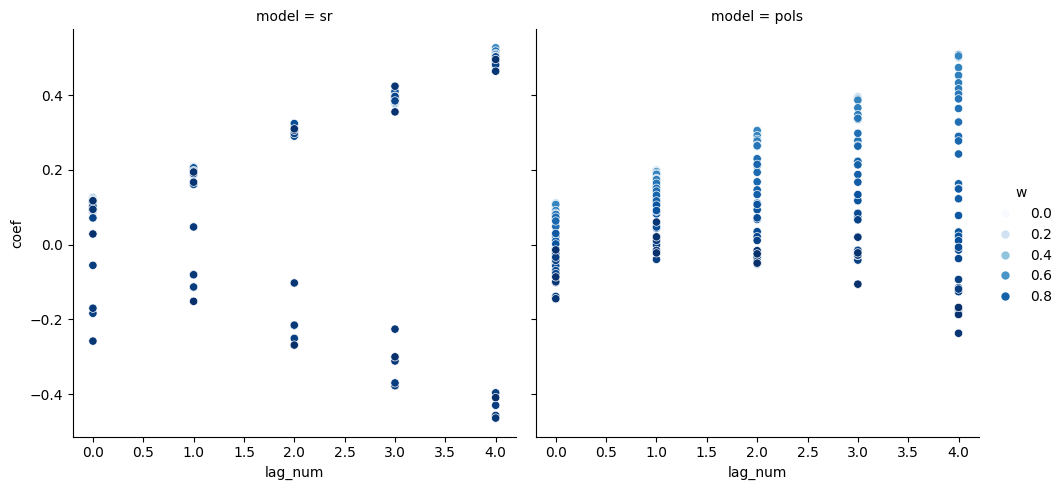

In [4]:
sns.relplot(y='coef', x = 'lag_num', hue='w', data=w_df_myfe, col='model', palette='Blues')

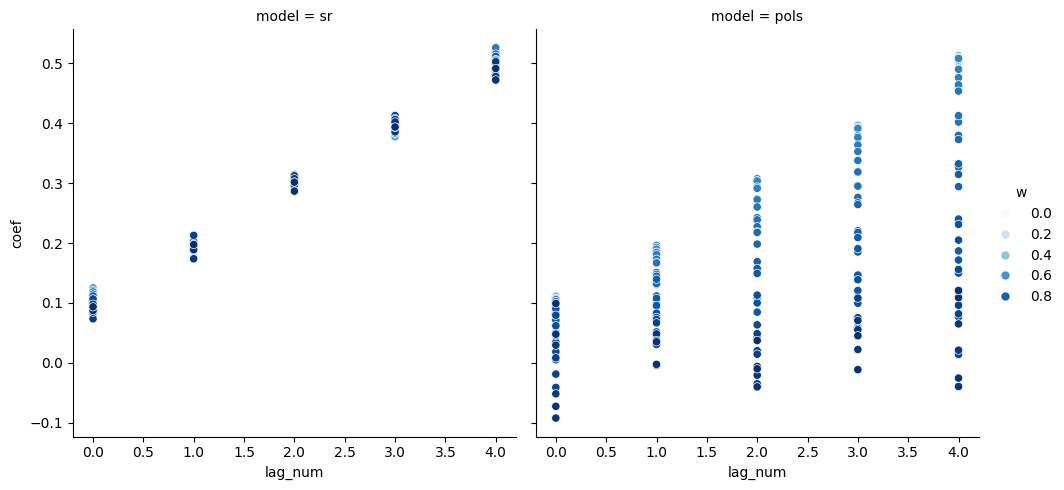

In [5]:
sns.relplot(y='coef', x = 'lag_num', hue='w', data=w_df_dfe, col='model', palette='Blues')

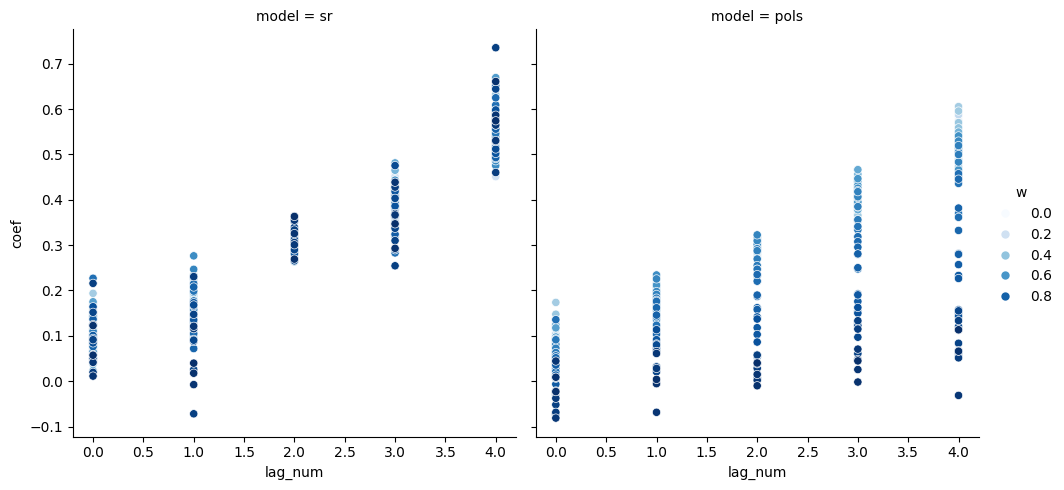

In [6]:
sns.relplot(y='coef', x = 'lag_num', hue='w', data=w_df_tfe_mis, col='model', palette='Blues')